https://arxiv.org/pdf/1406.2661.pdf

https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py


 Importing  libraries

In [1]:
# importing the required Libraries
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm # for progress bar
from tensorflow.keras import layers

We are loading fashion mnist data .The generator will generate fashion items resembling the fashion MNIST data.

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_images.shape
# here we loaded only as training data

(60000, 28, 28)

 Reshaping the images to add one more dimension i.e Channel. As the images are gray-scale so Channel dimension will be 1. Also,Normalizing the images to [-1, 1]because the generator’s final layer activation uses tanh

In [3]:
'''
- Neural networks works with batches of images
- Every image is represented in 3 dimensions -- Height, Width, Number of Channels
- Here we dont have the channel so we will add that by reshape method
- Since it is a grayscale image we set the number of channel as 1
'''
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images.shape

(60000, 28, 28, 1)

In [4]:
'''
- In a Grayscale image every pixel represents pixel intensity
--> retrieve a subarray that includes rows from index 56782, and the first 10 elements from the first two dimensions (assuming it's a 3D array).
--> Here we able to absorb that the numbers ranging from 0 to 255
'''
train_images[56782, :10, :10]

array([[[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  1.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 74.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 77.],
        [207.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [124.],
        [176.],
        [192.],
        [180.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [ 88.],
        [207.],
        [184.],
        [183.],
        [182.]],

       [[  0.],
        [  0

In [5]:
'''
- Neural Network works well when the numerical values are in lower sclae between 0 and 1
- The below followed method is a popular one for converting the image between -1 to 1
- Here we use 127.5 because 255/2 is 127.5 --> it is a simple rescale or normalization
- another reason to map the images in real dataset is that our fake image generated by generator model will have the same scaling
'''
train_images = (train_images - 127.5) / 127.5

train_images[56782, :10, :10]

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.41960785]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.39607844],
        [ 0.62352943]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
   

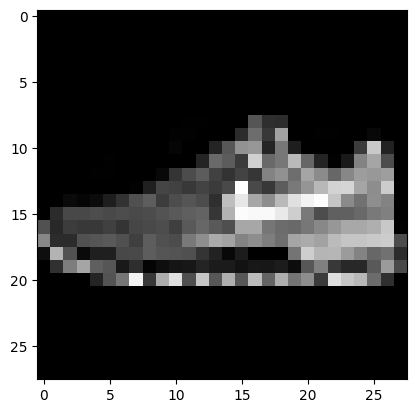

In [6]:
# lets see the single image in matplot lib

plt.imshow(train_images[2567].squeeze(), cmap = 'gray')

Training set is prepared by dividing the whole data into batches and shuffling it.

In [7]:
# Defining the batch and buffer size for shuffling the image
buffer_size = 60000
batch_size = 128

In [8]:
# we use the tensorflow dataset pipeline for transformations
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

Both the generator and discriminator are defined using the Keras Sequential API.

The generator uses tf.keras.layers.Dense layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then using Relu activations for each Dense layer.Note that activation in final layer is tanh which outputs in the range -1 to 1.
we reshape the 784-d tensor to (Batch Size, 28, 28, 1) using layers.Reshape function

In [9]:
'''
- here the generator model is the counter-feeder in this operation
- Responsibility of the generator model is to take in latent noise variables and generate fake images that
  look like real images
'''
def generator_model():

   # The generator model is a simple sequential model, meaning the connections between the layers
   # are one after the other
   # Every generator layer is a dense fully connected neural network followed by ReLU activation function
   # ReLU activation function -- makes the negative values as 0

    model = tf.keras.Sequential()
    # Input dimension set as 100 is the dimensionality of the latent noise variable that we feed into generator
    # inorder to generate images starting from noise
    # then we have 3 hidden layers 64, 128 and 256 neurons respectively
    model.add(layers.Dense(64, input_dim = 100))
    model.add(layers.ReLU())

    model.add(layers.Dense(128))
    model.add(layers.ReLU())

    model.add(layers.Dense(256))
    model.add(layers.ReLU())

    # output layer which uses the tanh function -- from -1 to 1
    # the size of the layer is 784 -- size of the output layer corresponds to size of the image generated by generator network
    # means 28 X 28 = 784 pixels, the size of the fake image is same as size of real image
    model.add(layers.Dense(784, activation = 'tanh'))

    # the objective of the generator is to generate realistic images
    # the 784 pixels that pick up our image, the flattened 784 pixels of our generated image are then reshaped to be
    # the same as a real image from trainng data which is 28 x 28 pixels and 1 channel
    model.add(layers.Reshape((28, 28, 1)))

    return model

Building the generator model and summary is obtained

In [10]:
generator = generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 re_lu_1 (ReLU)              (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 re_lu_2 (ReLU)              (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 784)               2

Using the (as yet untrained) generator to create an random gray scale image.

In [11]:
'''
-> example of how we would generate a latent noise variable vector in order to feed into Generator model
-> Here we use the tf.random normal function to generate Gaussian noise and vector size of 100
-> which is equal to input dimension of our model
-> We pass in the latent noise vector to our generator, set trainning to false to see what the generated image looks like
'''
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

generated_image.shape

#We can able to see that the shape of the generated image is a single image with batch size 1, 28 x 28 pixels and 1 channel

TensorShape([1, 28, 28, 1])

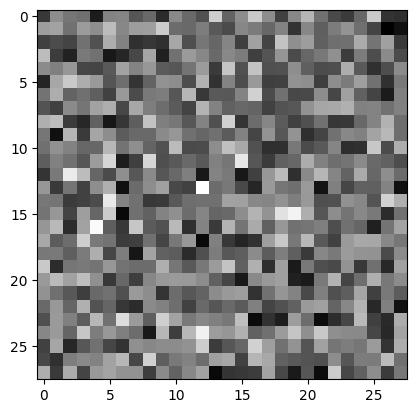

In [12]:
# Lets plot the generated image
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

# since the generator not trained yet the model model gave some random pixels as image

Note that the discriminator is a binary classifier, consisting  only of fully -connected layers. So, the discriminator expects a tensor of shape (Batch Size, 28, 28, 1). We are flattening out input to feed it into Dense layers. Each dense layer is having activation as LeakyRelu followed by drop out layers
The final layer has the sigmoid activation function, which squashes the output value between 0 (fake) and 1 (real).Note that we can also leave the last layer without sigmoid activation and use_logits=True in Binary Cross entropy function(which is recommended).

In [13]:
'''
- Remember the discriminator is a simple classification model
- It suppose to determine wheather the input image that has beed fed into is real or fake
- The discriminator model is also a sequential keras model
'''
def discriminator_model():
    model = tf.keras.Sequential()
    # Input to the keras model is 28 x 28 with single channel gray images
    # because we are building GAN using dense neural networks we need to flatten  this input image
    # so the image is represented as a single dimensional vector that is then passed to dense layers
    model.add(layers.Input(shape = (28, 28, 1)))
    model.add(layers.Flatten())

    # here we have 3 dense layers one after other
    # every layer uses LeakyReLU activation function -- it is beneficial for training and convergence of the model
    # The LeakyReLU is a modefication of the ReLU activation function
    # every dense layer is followed by a dropout layer to mitigate overfitting by turning off certain % of neurons during training process
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    # the last layer of the discriminator model is a dense layer with just a single neuron and sigmoid function
    # the output of the discriminator is a single probability score
    # The score represents the probability that the input image is real
    # the sigmoid activation will ensure that this probability score is with is range of 0 to 1
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

Building the discriminator model and summary is obtained

In [14]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)              

Here We are using  the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output values > 0.5  for real images, and values <0.5 for fake images.

In [15]:
# take the generated image that we got from untrained generator model and pass this through the discriminator
# our generated image was a pure noise, let's see what our untrained discriminater maked of this image
# let's see weather it considers it as real or fake
discriminator = discriminator_model()
output = discriminator(generated_image)
print (output)

# observe the probability score says 0.49 which is close to 50%
# which means the generator can't really tell wheather the input image was real or fake

tf.Tensor([[0.43530384]], shape=(1, 1), dtype=float32)


Now We are defining loss functions. In this case it is Binary Cross entropy as target is real or fake images

In [16]:
'''
- Now define the loss function
- Loss function here we use is Binary Cross Entropy
- It is typically used with classification models
- Since the discriminator is going to classify input images into two categories -- Real or fake, we can use binary cross entropy loss
  to train our discrimination model as we use the same loss to train our generator model
- We use the Binary Cross Entropy here because it heavily penalizes misclassification by the discriminator
- So of the discriminator take a fake image as classifies that as real, that'll be heavily penalized
'''

bce = tf.keras.losses.BinaryCrossentropy()

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [17]:
'''
- 1st let's define discriminator loss
- What is the objective of the discriminator?
---- it is to ensure that images from the real dataset are classified as real and images generated
----- by generator are classified as fake
- Real images as category 1 and fake images as category 0
'''

def discriminator_loss(real_output, fake_output):

    # real_output --> out of the discriminator for real images
    # fake_output --> output of the discriminator for fake images
    # now we use this to compute the loss

    # What is the loss of the discriminator on the real data?
      # we want the real data to be classified as 1's or real
      # output of the discriminator, we compare to a tensor of ones and this loss is the real loss of the discriminator
    real_loss = bce(tf.ones_like(real_output), real_output)

    # we want the discriminator to classify the fake images as 0's
      # we take the output of the discriminator on fake images and compare that out to  a tensor of all zeros
      # and we use that to compute the fake binary cross entropy loss
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    # the total loss of the discriminator is sum of these 2 losses
    # So, when we train the discriminator we try to minimize  the total loss of the discriminator
    # minimizing the loss is equivalent to maximizing the probability that the real images are classified as real
    # and generated images are classified as fake
    # Now training again involves training two different neural networks
      # the discriminator and generator
    # means we have to define the loss function for generator as well
    total_loss = real_loss + fake_loss

    return total_loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [18]:
# Loss function for generator
# fake_output --> output of the discriminator for fake data generated by the generator
# the objective of the generator is to fool the discriminator
# means the generator want to classify the fake image as real by the discriminator
# So, in order to compute the generator loss we take the output of the discriminator for fake data and
# compare that output to a tensor of all 1's
# when this loss is minimized the discriminator is classifying more and more of fake data as real
def generator_loss(fake_output):

    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    return gen_loss

The discriminator and the generator optimizers are different since  two networks would be trained separately.

In [19]:
# Let's setup the Optimizers for both the networks
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )

Following code demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [20]:
# setup a checkpoint directory for training
# this ensures that Tensorflow model checkpoints its training process at regular intervals
# is the training is interrupted for any reason it can pickup from the last checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# the tf train checkpoint takes in as an input argument the optimizers for the 2 neural networks

checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

We are using `tf.function`
This annotation causes the function to be "compiled".


In [21]:
# Defining the training process
epochs = 50
noise_dim = 100
# after every epoch of traiining we generate 16 examples from our GAN to see what the generated image looks like
# these 16 images will be generated using 16 different noise vectors, each of dimensionality hundred
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
# Define a python function annotated with TF function that defines single training step for GAN
# @tf.function is a python annotation that serves as a transformation tool and creates
  # Python independent data flow graphs out of python code
  # @tf.function applied to our train step, we'll generate our neural network graph
  # we take in images as an input argument. At every step we'll generate a batch of noise
  # which will be input to the generator model inorder to generate images

@tf.function
def train_step(images):
    # we take in images as an input argument. At every step we'll generate a batch of noise
    # which will be input to the generator model inorder to generate images
    noise = tf.random.normal([batch_size, noise_dim])

    # instantiate the gradient tape which is tensorflow library used to perform gradient descent in order to train neural networks
    # we are training two different neural networks for every pass through every batch of out data
    # that's by intantiate 2 gradient tapes --> gen_tape and disc_tape
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # we are going to be training  the generator and discriminator ultimately
        # 1st we will generate fake images from generator
        # we pass in out batch of noise to the generator and get generated images
        # because this is a training phase, we set training as true
        generated_images = generator(noise, training = True)

        # Once we have  the fake data output from generator we now use this to train the discriminator
        # Now we train the discriminator on real images as well as fake images
        # we pass the images from our training data on  line 30 --> it will give the output of discriminator for real_output
        # we then pass the generated images through the discriminator as well --> it will give
                # output of the discriminator for generated fake_output
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        # then we compute the discriminator loss by invoking the discriminator loss function that we setup earlier
        # it takes real and fake output
        disc_loss = discriminator_loss(real_output, fake_output)
        # we also compute the generator loss, which only takes in the fake output that is output of the discriminator on generator data
        gen_loss = generator_loss(fake_output)
    # once we have loss for both of our adversary networks we can use the gradient tape to compute the gradients for generator and discriminator

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # then we will use the optimizer to apply gradients and update the model parameters for both generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # for every batch of training we return bunch of information,
      # the generator loss, discriminator loss,
      # accuracy of the discriminator on real data and accuracy of the discriminator on fake data
    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

Notice `training` is set to False.
This is so all layers run in inference mode (batchnorm).
Function for generating and plotting images is defined

In [23]:
# during the training process we use this helper function to generate and plot images to get the generator
# to generate images from the test input that we have specified
def generate_and_plot_images(model, epoch, test_input):
    # the model here is the generator, we'll get the output of the generator for the test noise input that we had setup earlier
    predictions = model(test_input, training = False)

    # and we will plot this output using matplotlib
    # this will allow us to see how the generator improves over time
    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array(pred)
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [24]:
# the actual training of out GAN is carred out using this train function
# it takes dataset and number of epochs as input
def train(dataset, epochs):
    # we keep a list of losses for generator as well as discriminator for the purpose of plotting
    gen_loss_list = []
    disc_loss_list = []

    # we also track a list of accuracy scores for discriminator on real and fake data
    real_score_list =[]
    fake_score_list =[]

    # then we will run training for number of epochs
    # for every epochs of training we'll split our real training dataset into batches and feed in this data as one batch at a time
    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)

        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches...')

        # we also have variables for keeping track of total generator loss and total discriminator loss
        total_gen_loss = 0
        total_disc_loss = 0

        # for every batch of inputdata we invoke the train_step function to train our generator and discriminator on batch of data
        # we already seen how the train_step function generates fake images, feeds real as well as fake images to discriminator,
        # computes loss, computes gradients for both adversarial networks and updates bith the model parameters
        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            # we keep track of total generator and discriinator loss for every epoch and the compute the average loss for each epoch
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss

        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
        # Print out the average loss for both generator and discriminator
        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%'  %
              (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        # we also invoke the generate and plot images to feed in our test noise sample, that is our seed
            # and see what the output of the generator looks like after the current epoch of the training
        generate_and_plot_images(generator, epoch + 1, seed)

        # the next step here is to update the losses after every epoch as well as
        # the accuracy of the discriminator on the real and fake data after every epoch
        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        # makesure we are checkpointing for every 10 epochs
        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # from this function we will return generator loss, discriminator loss, and accuracy scores of real and fake fata
    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list

Finally, it’s time to train our  GAN model in Tensorflow. Taking the train_dataset and epochs as the parameters, the  train function calls the train_step function, at every new batch.At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look more real.

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 469 batches...
Losses after epoch     1: generator 1.754, discriminator 0.415, real_score 92.19%, fake_score 20.48%


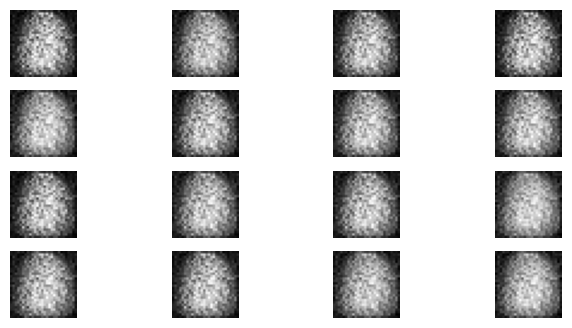

  2%|▏         | 1/50 [00:22<18:17, 22.40s/it]

Time for epoch 1 is 22.402541637420654 sec
Training started with  epoch 2 with 469 batches...
Losses after epoch     2: generator 2.415, discriminator 0.332, real_score 94.27%, fake_score 13.26%


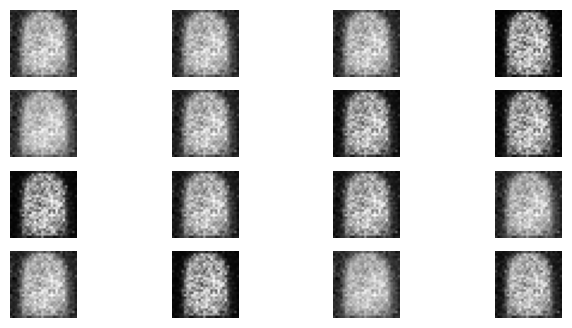

  4%|▍         | 2/50 [00:25<08:37, 10.79s/it]

Time for epoch 2 is 2.655966281890869 sec
Training started with  epoch 3 with 469 batches...
Losses after epoch     3: generator 1.725, discriminator 0.709, real_score 78.22%, fake_score 23.95%


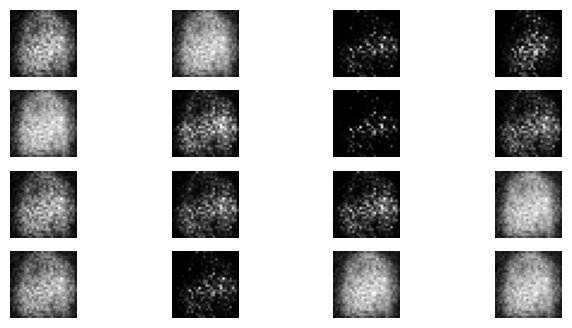

  6%|▌         | 3/50 [00:27<05:32,  7.07s/it]

Time for epoch 3 is 2.6495866775512695 sec
Training started with  epoch 4 with 469 batches...
Losses after epoch     4: generator 2.103, discriminator 0.571, real_score 83.93%, fake_score 21.66%


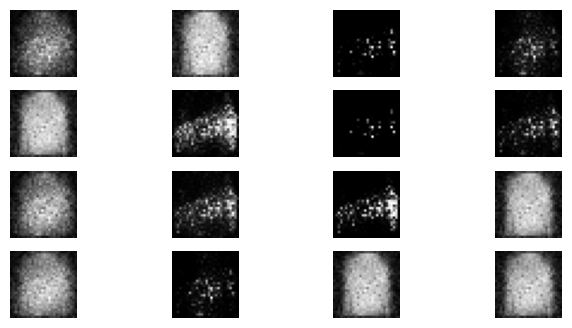

  8%|▊         | 4/50 [00:30<04:04,  5.32s/it]

Time for epoch 4 is 2.6359763145446777 sec
Training started with  epoch 5 with 469 batches...
Losses after epoch     5: generator 2.687, discriminator 0.309, real_score 91.11%, fake_score 13.51%


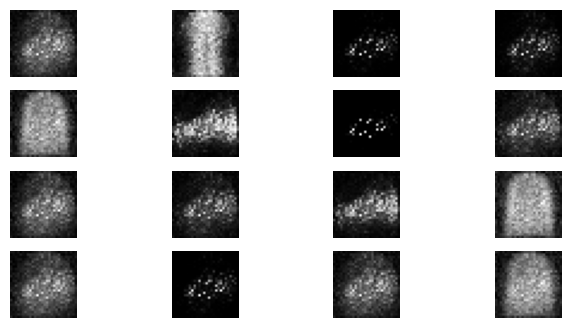

 10%|█         | 5/50 [00:33<03:27,  4.61s/it]

Time for epoch 5 is 3.3322527408599854 sec
Training started with  epoch 6 with 469 batches...
Losses after epoch     6: generator 3.183, discriminator 0.381, real_score 87.89%, fake_score 12.63%


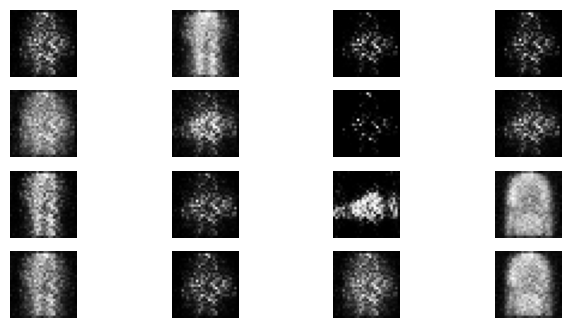

 12%|█▏        | 6/50 [00:37<03:04,  4.20s/it]

Time for epoch 6 is 3.4002535343170166 sec
Training started with  epoch 7 with 469 batches...
Losses after epoch     7: generator 2.263, discriminator 0.352, real_score 89.03%, fake_score 15.08%


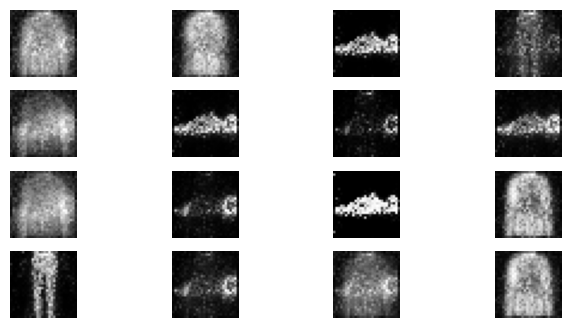

 14%|█▍        | 7/50 [00:39<02:38,  3.69s/it]

Time for epoch 7 is 2.6406514644622803 sec
Training started with  epoch 8 with 469 batches...
Losses after epoch     8: generator 1.675, discriminator 0.665, real_score 82.68%, fake_score 25.68%


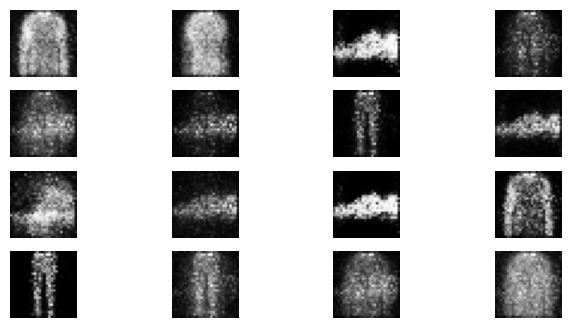

 16%|█▌        | 8/50 [00:42<02:21,  3.36s/it]

Time for epoch 8 is 2.6490237712860107 sec
Training started with  epoch 9 with 469 batches...
Losses after epoch     9: generator 1.828, discriminator 0.666, real_score 82.83%, fake_score 21.65%


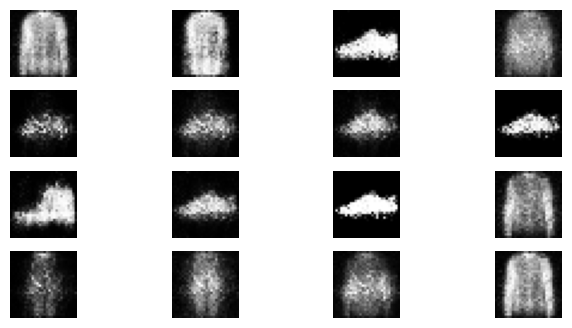

 18%|█▊        | 9/50 [00:45<02:08,  3.14s/it]

Time for epoch 9 is 2.6484262943267822 sec
Training started with  epoch 10 with 469 batches...
Losses after epoch    10: generator 2.961, discriminator 0.439, real_score 82.43%, fake_score 12.35%


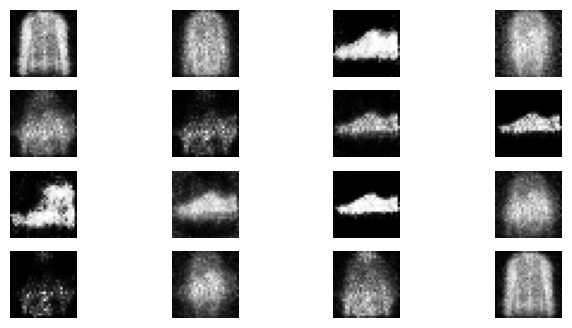

 20%|██        | 10/50 [00:48<02:15,  3.39s/it]

Time for epoch 10 is 3.9391891956329346 sec
Training started with  epoch 11 with 469 batches...
Losses after epoch    11: generator 2.014, discriminator 0.756, real_score 73.57%, fake_score 21.18%


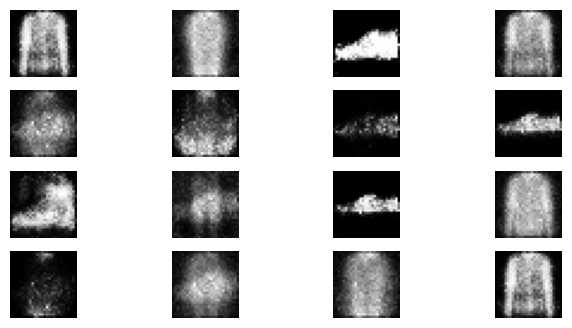

 22%|██▏       | 11/50 [00:51<02:04,  3.18s/it]

Time for epoch 11 is 2.713505268096924 sec
Training started with  epoch 12 with 469 batches...
Losses after epoch    12: generator 2.808, discriminator 0.526, real_score 85.07%, fake_score 16.48%


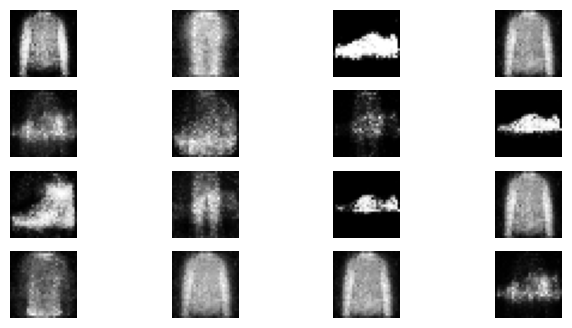

 24%|██▍       | 12/50 [00:54<01:54,  3.01s/it]

Time for epoch 12 is 2.606576681137085 sec
Training started with  epoch 13 with 469 batches...
Losses after epoch    13: generator 1.523, discriminator 1.072, real_score 76.53%, fake_score 31.01%


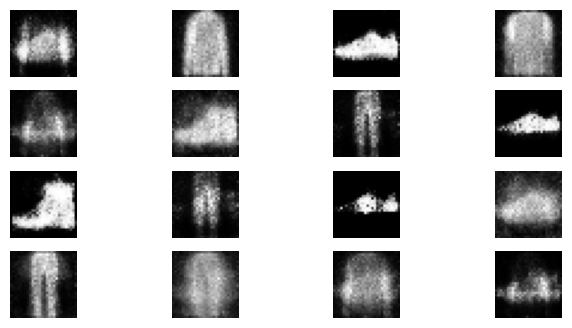

 26%|██▌       | 13/50 [00:56<01:47,  2.90s/it]

Time for epoch 13 is 2.653188705444336 sec
Training started with  epoch 14 with 469 batches...
Losses after epoch    14: generator 2.552, discriminator 0.975, real_score 74.29%, fake_score 20.89%


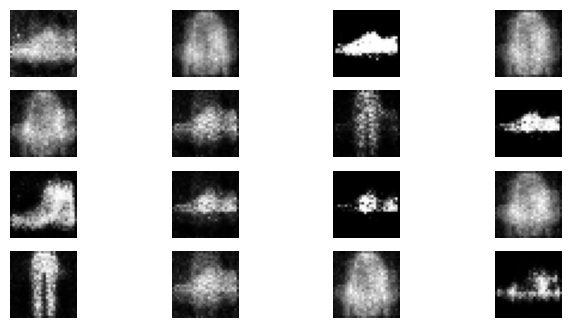

 28%|██▊       | 14/50 [01:00<01:48,  3.00s/it]

Time for epoch 14 is 3.226731061935425 sec
Training started with  epoch 15 with 469 batches...
Losses after epoch    15: generator 1.795, discriminator 0.848, real_score 77.49%, fake_score 25.48%


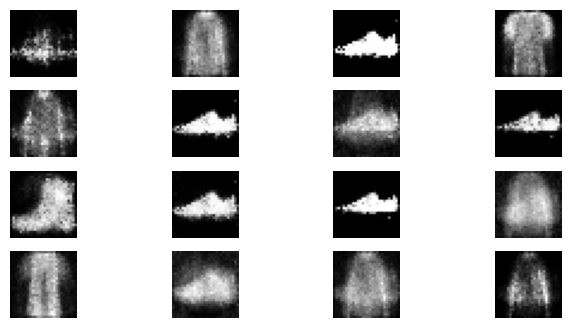

 30%|███       | 15/50 [01:05<02:13,  3.82s/it]

Time for epoch 15 is 5.707820653915405 sec
Training started with  epoch 16 with 469 batches...
Losses after epoch    16: generator 2.536, discriminator 0.429, real_score 87.35%, fake_score 15.33%


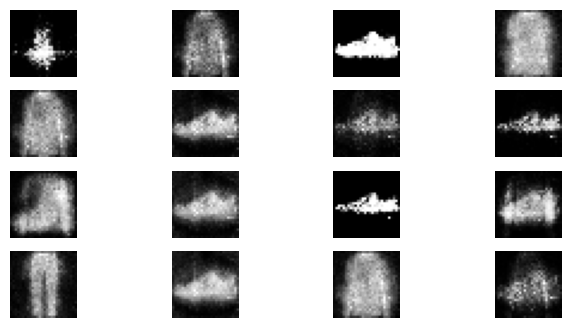

 32%|███▏      | 16/50 [01:08<01:57,  3.45s/it]

Time for epoch 16 is 2.6045162677764893 sec
Training started with  epoch 17 with 469 batches...
Losses after epoch    17: generator 2.182, discriminator 0.743, real_score 73.88%, fake_score 19.86%


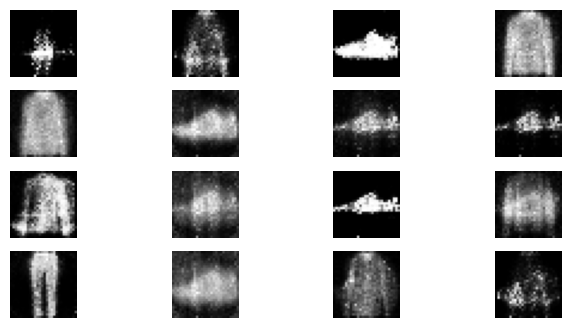

 34%|███▍      | 17/50 [01:11<01:46,  3.22s/it]

Time for epoch 17 is 2.6821742057800293 sec
Training started with  epoch 18 with 469 batches...
Losses after epoch    18: generator 2.142, discriminator 0.826, real_score 74.20%, fake_score 21.27%


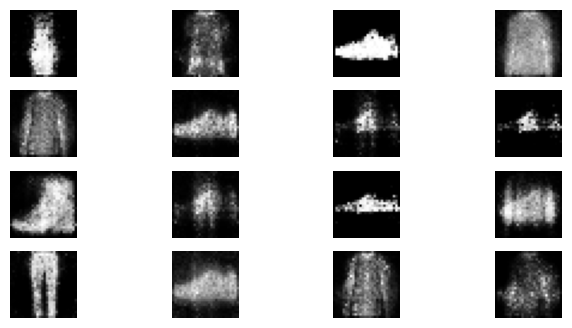

 36%|███▌      | 18/50 [01:14<01:44,  3.27s/it]

Time for epoch 18 is 3.3890185356140137 sec
Training started with  epoch 19 with 469 batches...
Losses after epoch    19: generator 2.565, discriminator 0.568, real_score 86.24%, fake_score 17.23%


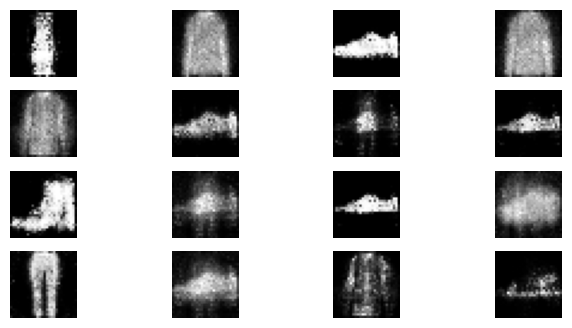

 38%|███▊      | 19/50 [01:17<01:40,  3.25s/it]

Time for epoch 19 is 3.172220468521118 sec
Training started with  epoch 20 with 469 batches...
Losses after epoch    20: generator 1.788, discriminator 0.624, real_score 84.48%, fake_score 26.23%


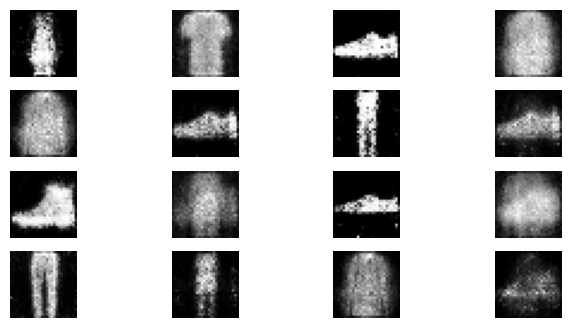

 40%|████      | 20/50 [01:20<01:33,  3.10s/it]

Time for epoch 20 is 2.7647624015808105 sec
Training started with  epoch 21 with 469 batches...
Losses after epoch    21: generator 1.641, discriminator 0.810, real_score 78.90%, fake_score 28.07%


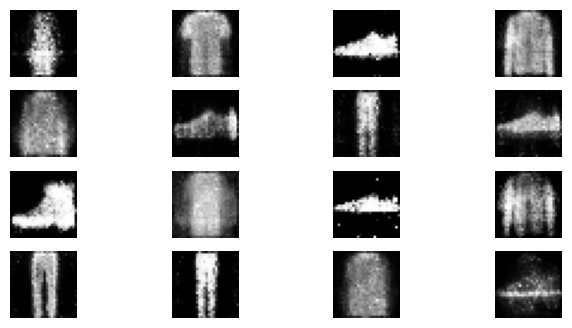

 42%|████▏     | 21/50 [01:23<01:26,  2.97s/it]

Time for epoch 21 is 2.651015520095825 sec
Training started with  epoch 22 with 469 batches...
Losses after epoch    22: generator 1.618, discriminator 0.882, real_score 65.73%, fake_score 24.18%


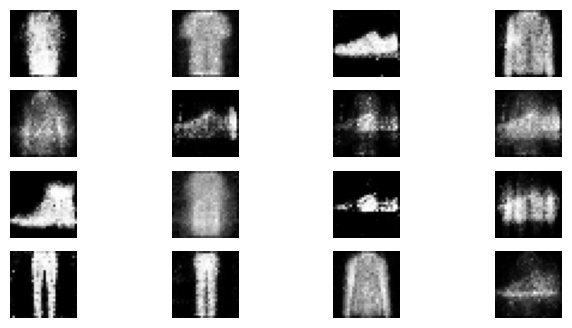

 44%|████▍     | 22/50 [01:26<01:22,  2.96s/it]

Time for epoch 22 is 2.9456980228424072 sec
Training started with  epoch 23 with 469 batches...
Losses after epoch    23: generator 2.522, discriminator 0.430, real_score 85.29%, fake_score 14.01%


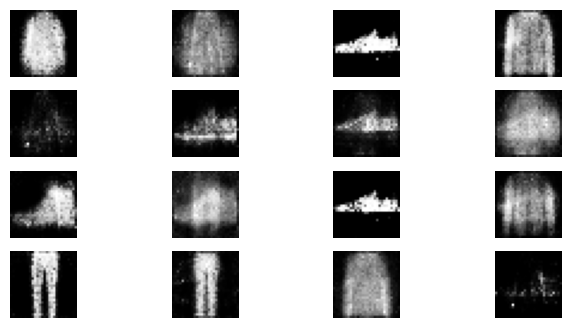

 46%|████▌     | 23/50 [01:29<01:23,  3.10s/it]

Time for epoch 23 is 3.4227054119110107 sec
Training started with  epoch 24 with 469 batches...
Losses after epoch    24: generator 1.474, discriminator 1.176, real_score 70.18%, fake_score 31.90%


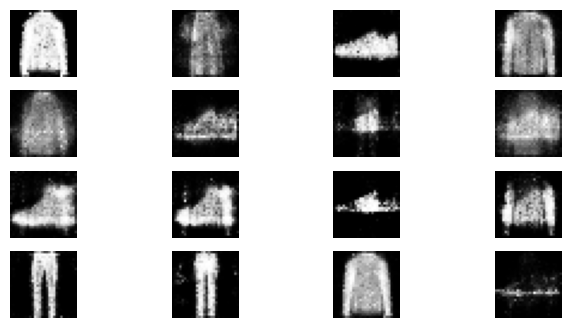

 48%|████▊     | 24/50 [01:32<01:18,  3.03s/it]

Time for epoch 24 is 2.8742949962615967 sec
Training started with  epoch 25 with 469 batches...
Losses after epoch    25: generator 2.335, discriminator 0.696, real_score 78.67%, fake_score 17.97%


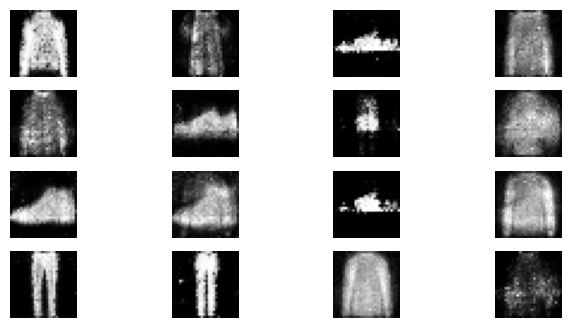

 50%|█████     | 25/50 [01:35<01:13,  2.93s/it]

Time for epoch 25 is 2.6853275299072266 sec
Training started with  epoch 26 with 469 batches...
Losses after epoch    26: generator 2.756, discriminator 0.536, real_score 78.62%, fake_score 12.94%


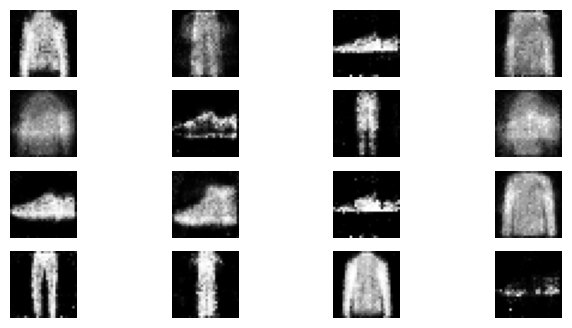

 52%|█████▏    | 26/50 [01:38<01:10,  2.93s/it]

Time for epoch 26 is 2.92342472076416 sec
Training started with  epoch 27 with 469 batches...
Losses after epoch    27: generator 2.526, discriminator 0.566, real_score 76.70%, fake_score 13.42%


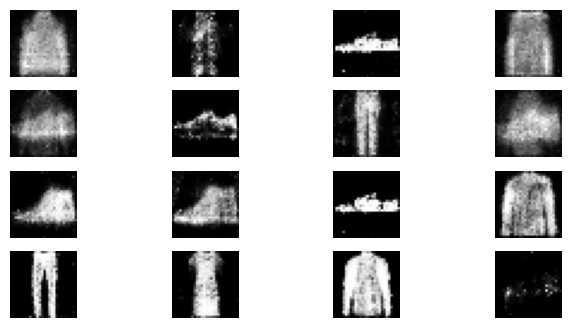

 54%|█████▍    | 27/50 [01:40<01:07,  2.91s/it]

Time for epoch 27 is 2.8647165298461914 sec
Training started with  epoch 28 with 469 batches...
Losses after epoch    28: generator 1.535, discriminator 0.913, real_score 75.98%, fake_score 30.79%


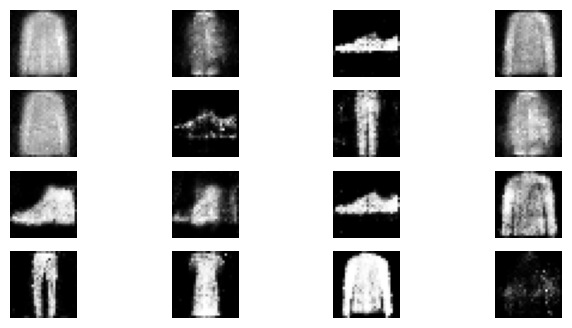

 56%|█████▌    | 28/50 [01:46<01:22,  3.75s/it]

Time for epoch 28 is 5.687267065048218 sec
Training started with  epoch 29 with 469 batches...
Losses after epoch    29: generator 2.280, discriminator 0.679, real_score 81.43%, fake_score 19.96%


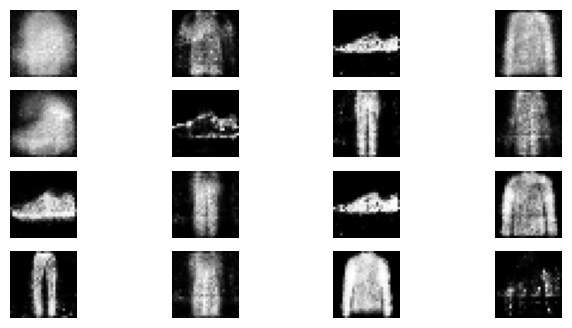

 58%|█████▊    | 29/50 [01:49<01:11,  3.42s/it]

Time for epoch 29 is 2.667698860168457 sec
Training started with  epoch 30 with 469 batches...
Losses after epoch    30: generator 2.253, discriminator 0.626, real_score 75.55%, fake_score 16.83%


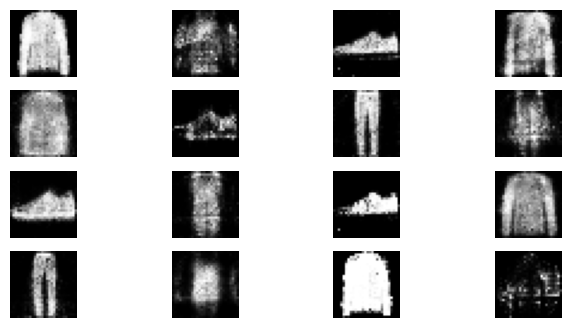

 60%|██████    | 30/50 [01:52<01:05,  3.30s/it]

Time for epoch 30 is 3.008288860321045 sec
Training started with  epoch 31 with 469 batches...
Losses after epoch    31: generator 2.511, discriminator 0.627, real_score 78.87%, fake_score 16.76%


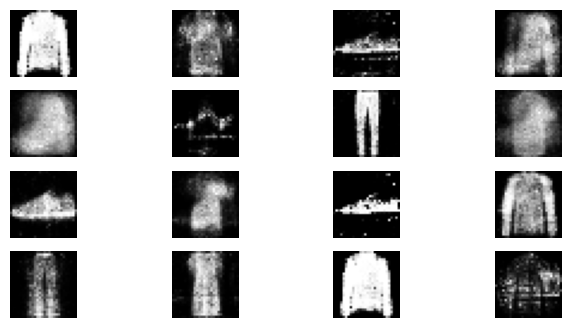

 62%|██████▏   | 31/50 [01:55<01:01,  3.23s/it]

Time for epoch 31 is 3.068021774291992 sec
Training started with  epoch 32 with 469 batches...
Losses after epoch    32: generator 2.380, discriminator 0.480, real_score 83.48%, fake_score 15.62%


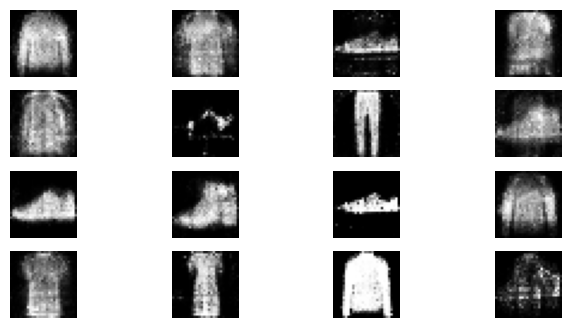

 64%|██████▍   | 32/50 [01:58<00:58,  3.24s/it]

Time for epoch 32 is 3.245415210723877 sec
Training started with  epoch 33 with 469 batches...
Losses after epoch    33: generator 2.261, discriminator 0.920, real_score 76.48%, fake_score 24.32%


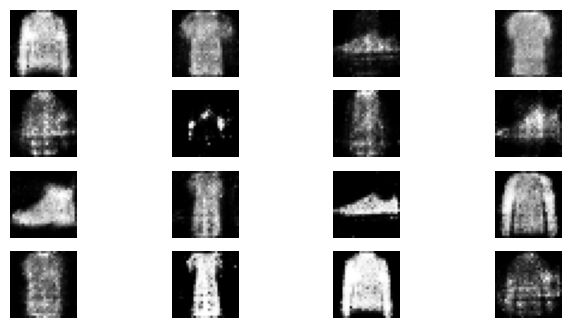

 66%|██████▌   | 33/50 [02:01<00:54,  3.19s/it]

Time for epoch 33 is 3.085840940475464 sec
Training started with  epoch 34 with 469 batches...
Losses after epoch    34: generator 1.783, discriminator 0.963, real_score 76.04%, fake_score 27.86%


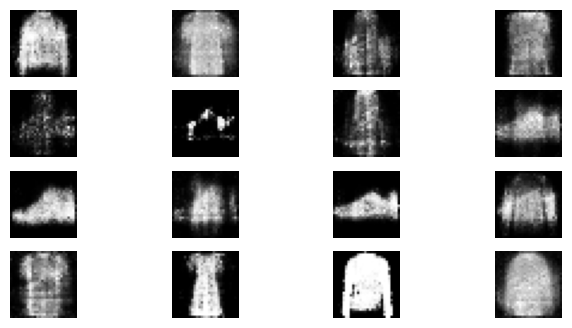

 68%|██████▊   | 34/50 [02:04<00:48,  3.05s/it]

Time for epoch 34 is 2.7084970474243164 sec
Training started with  epoch 35 with 469 batches...
Losses after epoch    35: generator 1.963, discriminator 0.565, real_score 85.33%, fake_score 22.46%


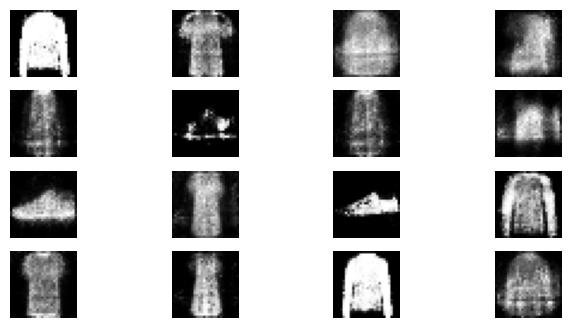

 70%|███████   | 35/50 [02:07<00:46,  3.08s/it]

Time for epoch 35 is 3.150644540786743 sec
Training started with  epoch 36 with 469 batches...
Losses after epoch    36: generator 2.670, discriminator 0.490, real_score 83.83%, fake_score 18.52%


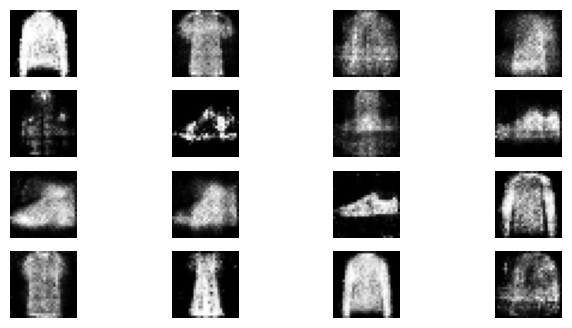

 72%|███████▏  | 36/50 [02:12<00:51,  3.68s/it]

Time for epoch 36 is 5.059446811676025 sec
Training started with  epoch 37 with 469 batches...
Losses after epoch    37: generator 1.836, discriminator 0.813, real_score 75.27%, fake_score 25.99%


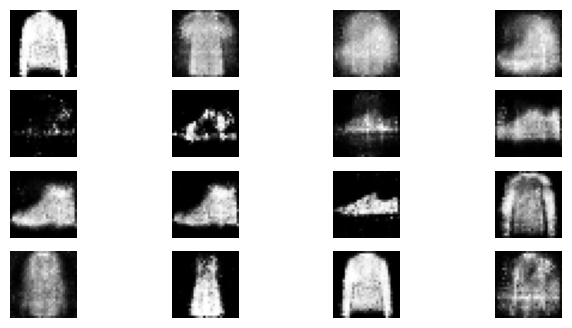

 74%|███████▍  | 37/50 [02:15<00:44,  3.39s/it]

Time for epoch 37 is 2.725853204727173 sec
Training started with  epoch 38 with 469 batches...
Losses after epoch    38: generator 2.513, discriminator 0.622, real_score 78.18%, fake_score 16.78%


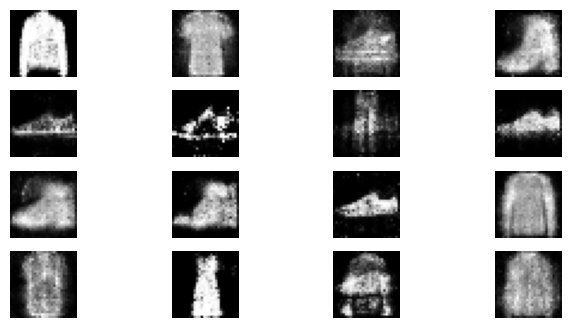

 76%|███████▌  | 38/50 [02:18<00:38,  3.19s/it]

Time for epoch 38 is 2.707090139389038 sec
Training started with  epoch 39 with 469 batches...
Losses after epoch    39: generator 1.965, discriminator 0.723, real_score 72.61%, fake_score 20.13%


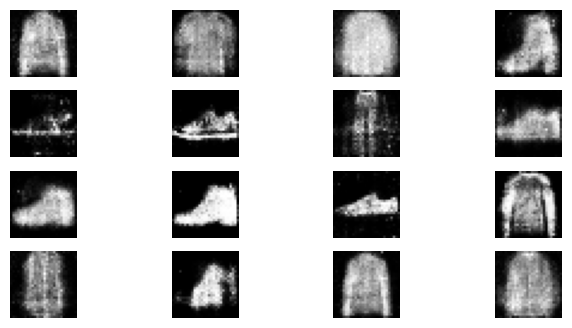

 78%|███████▊  | 39/50 [02:21<00:34,  3.11s/it]

Time for epoch 39 is 2.9298031330108643 sec
Training started with  epoch 40 with 469 batches...
Losses after epoch    40: generator 2.099, discriminator 0.852, real_score 70.91%, fake_score 23.30%


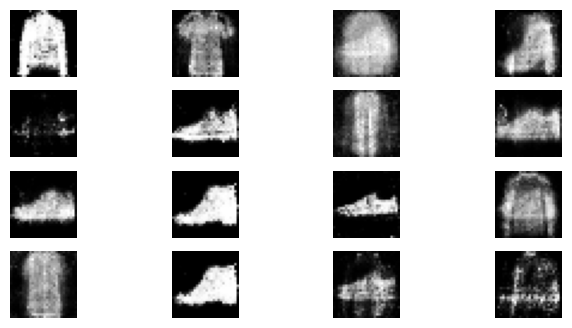

 80%|████████  | 40/50 [02:24<00:32,  3.23s/it]

Time for epoch 40 is 3.512579917907715 sec
Training started with  epoch 41 with 469 batches...
Losses after epoch    41: generator 2.423, discriminator 0.525, real_score 87.47%, fake_score 20.19%


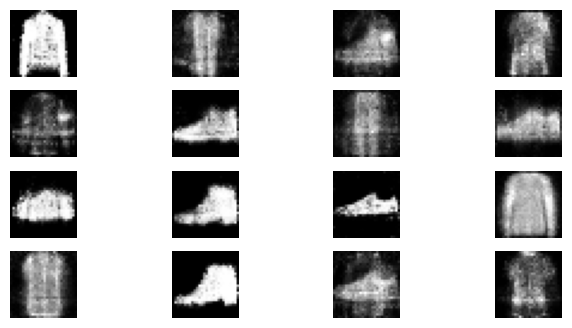

 82%|████████▏ | 41/50 [02:27<00:28,  3.16s/it]

Time for epoch 41 is 2.975687026977539 sec
Training started with  epoch 42 with 469 batches...
Losses after epoch    42: generator 2.475, discriminator 0.989, real_score 73.57%, fake_score 23.69%


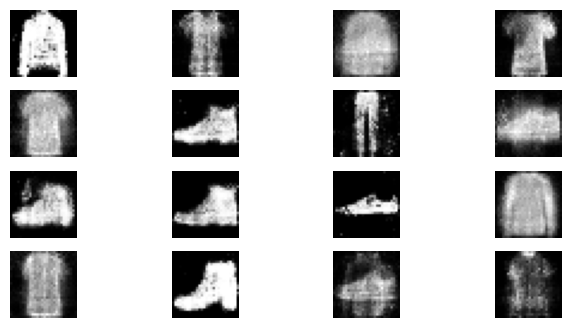

 84%|████████▍ | 42/50 [02:30<00:24,  3.02s/it]

Time for epoch 42 is 2.71030330657959 sec
Training started with  epoch 43 with 469 batches...
Losses after epoch    43: generator 2.069, discriminator 0.660, real_score 78.18%, fake_score 22.13%


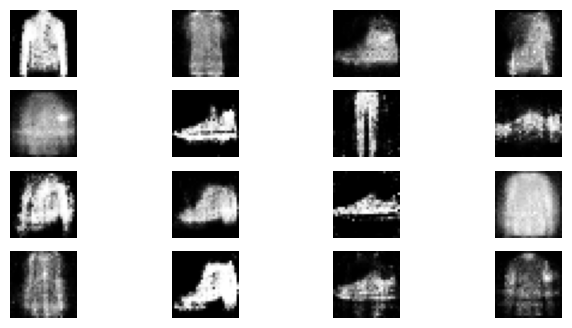

 86%|████████▌ | 43/50 [02:33<00:21,  3.01s/it]

Time for epoch 43 is 2.969019651412964 sec
Training started with  epoch 44 with 469 batches...
Losses after epoch    44: generator 1.934, discriminator 0.767, real_score 81.98%, fake_score 27.08%


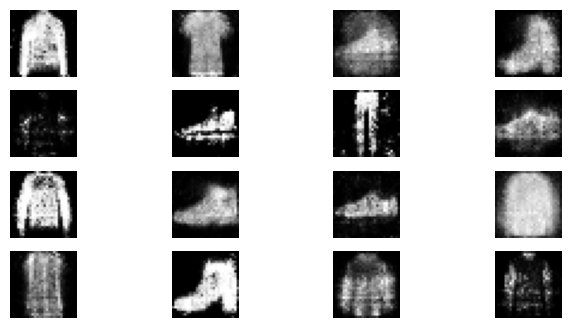

 88%|████████▊ | 44/50 [02:36<00:17,  2.99s/it]

Time for epoch 44 is 2.9307940006256104 sec
Training started with  epoch 45 with 469 batches...
Losses after epoch    45: generator 1.270, discriminator 1.390, real_score 60.53%, fake_score 34.99%


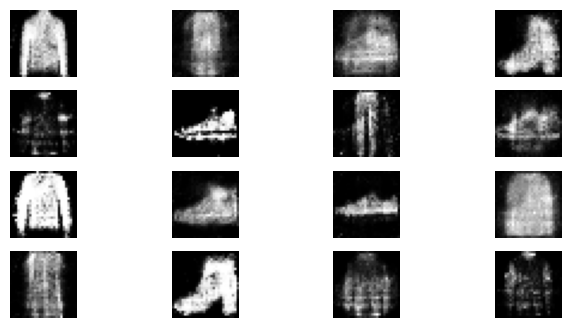

 90%|█████████ | 45/50 [02:39<00:15,  3.16s/it]

Time for epoch 45 is 3.5757505893707275 sec
Training started with  epoch 46 with 469 batches...
Losses after epoch    46: generator 3.972, discriminator 0.352, real_score 85.48%, fake_score 9.31%


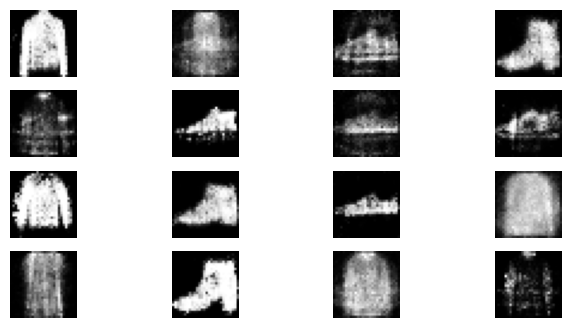

 92%|█████████▏| 46/50 [02:42<00:12,  3.03s/it]

Time for epoch 46 is 2.7270967960357666 sec
Training started with  epoch 47 with 469 batches...
Losses after epoch    47: generator 2.387, discriminator 0.775, real_score 74.29%, fake_score 19.20%


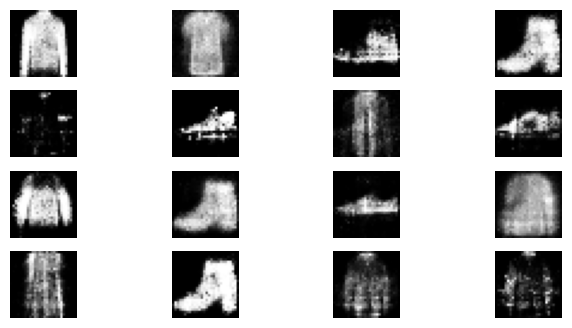

 94%|█████████▍| 47/50 [02:45<00:09,  3.03s/it]

Time for epoch 47 is 3.0103535652160645 sec
Training started with  epoch 48 with 469 batches...
Losses after epoch    48: generator 1.737, discriminator 0.903, real_score 71.52%, fake_score 29.75%


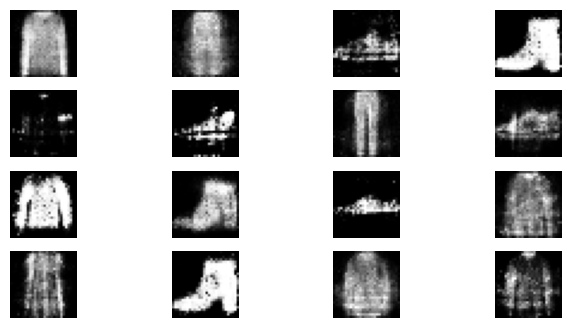

 96%|█████████▌| 48/50 [02:48<00:05,  2.93s/it]

Time for epoch 48 is 2.705233573913574 sec
Training started with  epoch 49 with 469 batches...
Losses after epoch    49: generator 1.894, discriminator 0.675, real_score 74.81%, fake_score 21.26%


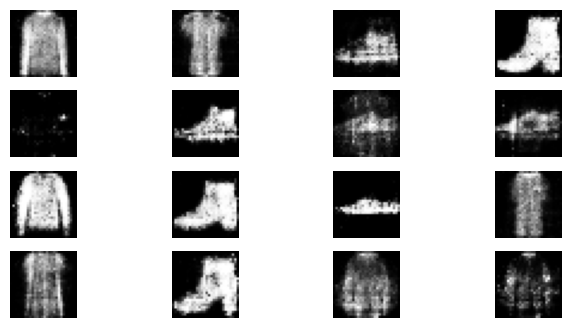

 98%|█████████▊| 49/50 [02:51<00:03,  3.01s/it]

Time for epoch 49 is 3.198119878768921 sec
Training started with  epoch 50 with 469 batches...
Losses after epoch    50: generator 2.537, discriminator 0.734, real_score 71.55%, fake_score 16.06%


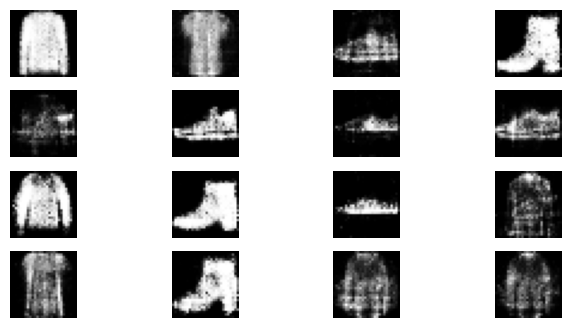

100%|██████████| 50/50 [02:54<00:00,  3.49s/it]

Time for epoch 50 is 3.305971145629883 sec


In [25]:
'''
- We setup our generative adversarial network --> Generator and Discriminator
- We defined the loss function
- We setup the optimmizer
- We defined the functions for training our GAN model
'''
# we can initiate the training by invoking the train function
# the train function takes in the training dataset and number of epochs of training
# we are going to training for 50 epochs
# the train function calles train_step to train neural network on single batch of data

gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs = epochs)

# within few minutes we get the output of the generator after 1 epoch of training, well the generator hasn't learned very much yet,
# all of the generated images are just blobs
# As we continue training after 5 epochs we can see that blobs begin to take on shapes
# from the same noise input the generated images are far better
# At around epoch 18-- now it looks like fashion accessories-- we able to see the clear picture
# at epoch 38 the generated images are much better
# at epoch 50 the images are fairly decent, they're not great, this is because our GAN has been built using
# fully connected neurons
# Convolutional neural networks will do better which is better for working with images



Plotting visualisations for Losses and Scores

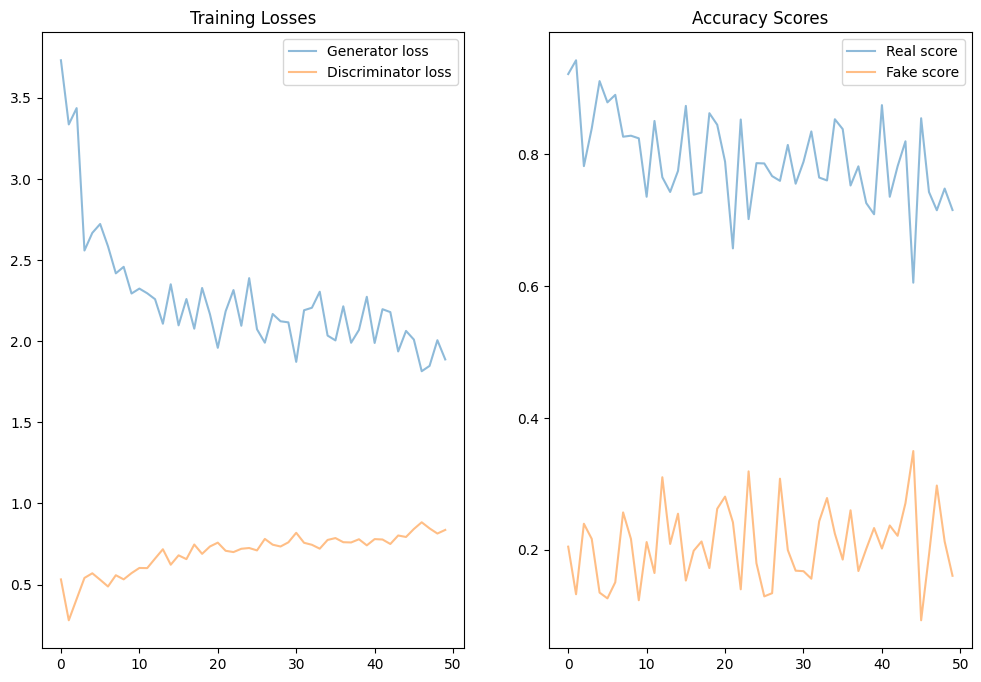

In [26]:
# after training the GAN lets plot generator loss, discriminator loss and score of discriminator for real and fake data
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()

# The generated images from the generator constantly improve over time until the generator is able to fool the discriminator
# this is why the generator loss falls over time
# the dscriminator starts well -- it able to discriminate between real and fake images well
# as the fake images gets better the discriminators performance becomes worse over time
# We can see that the discriminator loss increases overtime
# the objective of the generatot is to consistently fool the discriminator till the discriminator can no longer tell difference
# between real and fake images
# The accuracy scores here dont really have pattern but they seems to be converging to 0.5 which is what we want
# End objective of GAN is to have the discriminator so confused about real and fake images
# that the probability of it getting an image correctly classified is about 50% that's the trend we see here at accuracy scores